In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Map configurations and Visualization

config number 0 --------------


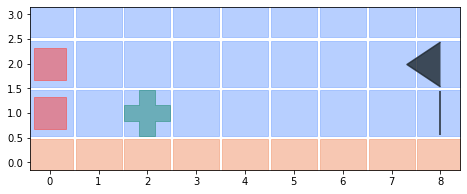

config number 1 --------------


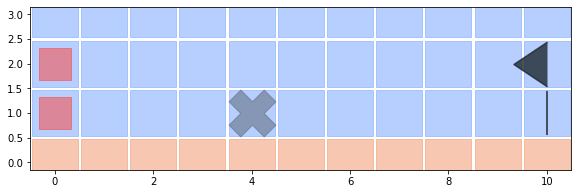

config number 2 --------------


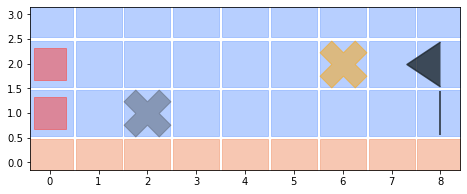

config number 3 --------------


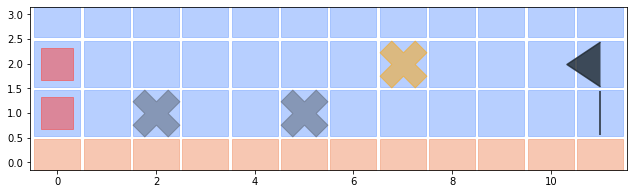

config number 4 --------------


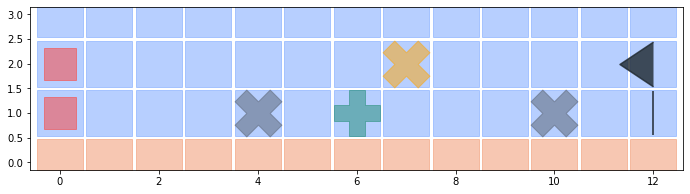

config number 5 --------------


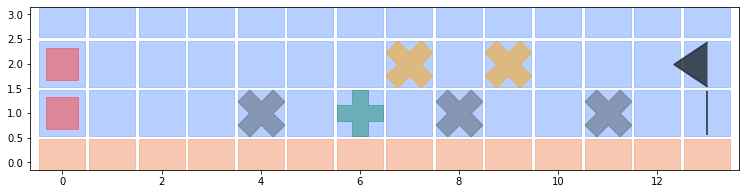

config number 6 --------------


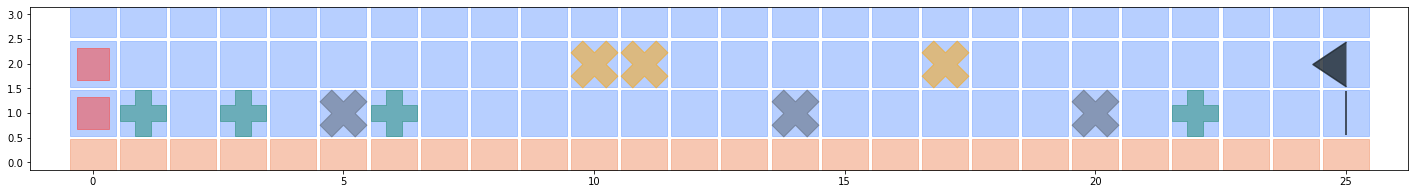

config number 7 --------------


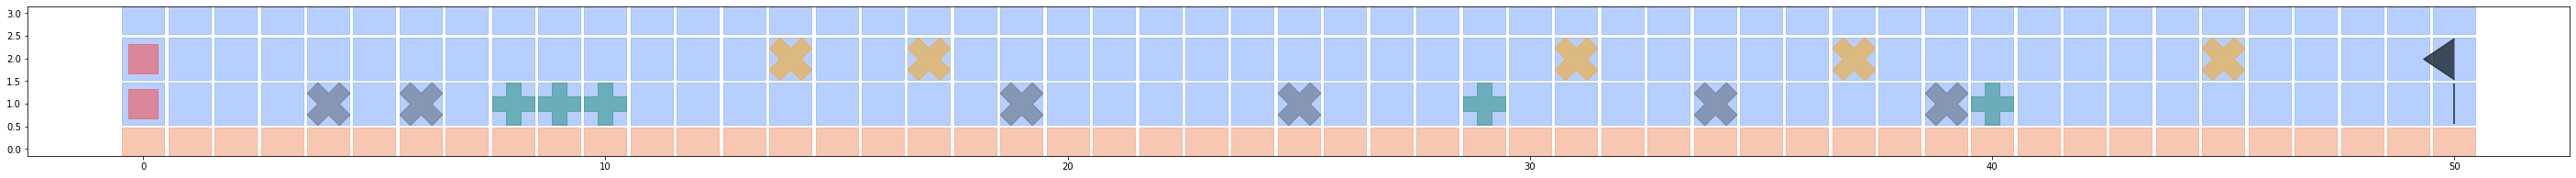

config number 8 --------------


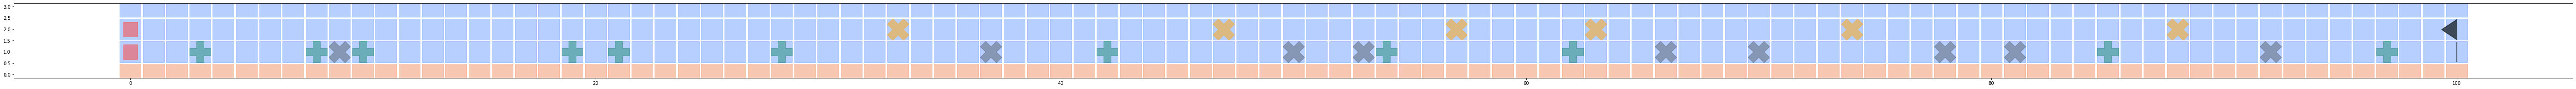

config number 9 --------------


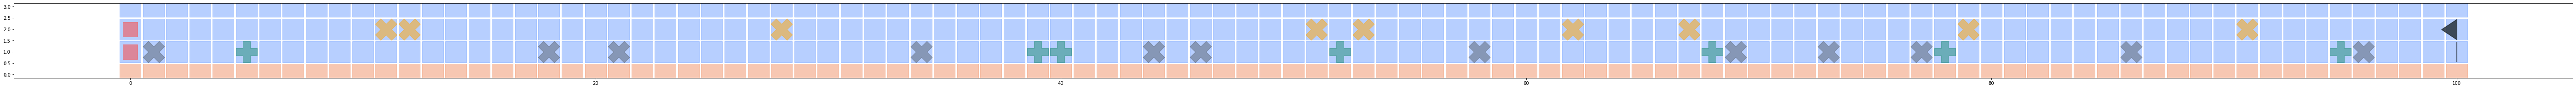

In [102]:
# height of each element of map in plot (visualizing)
ground_y = 1
goomba_y = 1
mushroom_y = 1
lakitu_y = 2
top_y = 3

# reading map file and organize data in an dictionary
def setup_map_config(file_name):
    
    file = open(file_name)
    line = file.readline()
    header = line.strip()
    
    goomba = []

    ground   = [i for i, x in enumerate(line) if x == "_"] # y = 1
    goomba   = [i for i, x in enumerate(line) if x == "G"] # y = 1
    mushroom = [i for i, x in enumerate(line) if x == "M"] # y = 1
    lakitu   = [i for i, x in enumerate(line) if x == "L"] # y = 2
    luigi    = [(0, ground_y), (0, ground_y + 1)]
    
    sky = []
    for i in range(len(line) + 1):
            sky.append((i, ground_y))
            sky.append((i, lakitu_y))
            sky.append((i, top_y))
            
    return {
        'level'    : line,
        'ground'   : ground,
        'goomba'   : goomba,
        'lakitu'   : lakitu, 
        'mushroom' : mushroom,
        'sky'      : sky,
        'luigi'    : luigi,
    }


# visualizer
def draw_config(config, save=False, path=None ,file_name=None, show=True, dpi=100):
    
    level    = config['level']
    ground   = config['ground']
    goomba   = config['goomba']
    lakitu   = config['lakitu']
    mushroom = config['mushroom']
    sky      = config['sky']
    luigi    = config['luigi']
    
    map_size = len(level)

    fig = plt.figure(figsize=(map_size - 0.3, 3))
    kwargs = {
        's'          : 2200,
        'c'          : '#c0392b',
        'marker'     : "s",
        'alpha'      : 0.5,
    }
    
    scale = 1.0
    # base
    kwargs['c'] = "#f19066"
    kwargs['marker'] = 's'
    n = [(b / scale, 0) for b in range(map_size + 1)]
    plt.scatter([x[0] for x in n], [x[1] for x in n], **kwargs)

    # sky
    kwargs['c'] = "#70a1ff"
    kwargs['marker'] = 's'
    plt.scatter([s[0] / scale for s in sky], [s[1] for s in sky], **kwargs)
    
    # goomba
    kwargs['c'] = "#57606f"
    kwargs['marker'] = 'X'
    n = [(g, goomba_y) for g in goomba]
    plt.scatter([x[0] / scale for x in n], [x[1] for x in n], **kwargs)
    
    # mushroom
    kwargs['c'] = "#218c74"
    kwargs['marker'] = 'P'
    n = [(m, mushroom_y) for m in mushroom]
    plt.scatter([x[0] / scale for x in n], [x[1] for x in n], **kwargs)
    
    # lakitu
    kwargs['c'] = "#ffa502"
    kwargs['marker'] = 'X'
    n = [(l, lakitu_y) for l in lakitu]
    scat = plt.scatter([x[0] / scale for x in n], [x[1] for x in n], **kwargs)
    
    # luigi
    kwargs['c'] = "#ff3f34"
    kwargs['s'] = 1000
    if len(luigi) == 1:
        kwargs['marker'] = 's'
        scat = plt.scatter(luigi[0][0], luigi[0][1], **kwargs)
    else:
        kwargs['marker'] = 's'
        scat = plt.scatter(luigi[1][0], luigi[1][1], **kwargs)
        
        kwargs['marker'] = 's'
        scat = plt.scatter(luigi[0][0], luigi[0][1], **kwargs)
        
    # flag
    kwargs['s'] = 2000
    kwargs['c'] = "#1e272e"
    kwargs['marker'] = '|'
    kwargs['alpha'] = 1
    plt.scatter(map_size, ground_y, **kwargs)
    kwargs['marker'] = 8
    kwargs['alpha'] = 0.8
    plt.scatter(map_size, ground_y + 1, **kwargs)
    
    ax = scat.axes
#     ax.invert_yaxis()

    if show:
        plt.show()
    if save:
        from pathlib import Path
        if not path:
            path = "../default_export_path/"
        Path(path).mkdir(parents=True, exist_ok=True)
        fig.savefig(f'{path}/{file_name}', dpi=dpi)
        plt.close(fig)

        
# -----------------------------------------------------
# making configuration dictinaries
inputs = [
    "../attachments/levels/level1.txt",
    "../attachments/levels/level2.txt",
    "../attachments/levels/level3.txt",
    "../attachments/levels/level4.txt",
    "../attachments/levels/level5.txt",
    "../attachments/levels/level6.txt",
    "../attachments/levels/level7.txt",
    "../attachments/levels/level8.txt",
    "../attachments/levels/level9.txt",
    "../attachments/levels/level10.txt",
]

# this list maintains all config dictionaries
# each cofig dictinary has information about map and elements in it

main_configurations = [setup_map_config(f) for f in inputs]
for index,c in enumerate(main_configurations):
    print(f'config number {index} --------------')
    draw_config(c, save=True, path="../output/configs", file_name=f"{index}.png")

## Game class
### containing game logic and score calculator

In [60]:
import copy
import math
import random

class State():
    S = 0 # standing (on land - two blocks)
    F = 1 # floating (in air - two blocks)
    D = 2 # dodging (on land - one block)


# Game is based on a level (map configuration dictionary)
class Game:
    def __init__(self, configuration):
        self.configuration = configuration
        self.level = configuration['level']
        self.level = self.level + 'F' # this is for flag
        
        
    # state machine for interpreting actions as states [it is easier for calculating score]
    # gets action sequence and returns states of Luigi on map
    def state_generator(self, action_sequence):
        state = State.S
        next_state = None

        states = [state]
        for index, s in enumerate(action_sequence):
            if state == State.S:
                if s == '0': next_state = State.S
                if s == '1': next_state = State.F
                if s == '2': next_state = State.D
                    
            elif state == State.F:
                if s == '0': next_state = State.S
                if s == '1': next_state = State.S
                if s == '2': next_state = State.S
                    
            elif state == State.D:
                if s == '0': next_state = State.S
                if s == '1': next_state = State.F
                if s == '2': next_state = State.D
            states.append(next_state)
            state = next_state
        return states
        
    
    # calculating score 
    # gets a sequence of actions and calculating score of that actions on the level
    def score(self, action_sequence):
        if len(action_sequence) + 1 != len(self.level):
            return None
        
        situations = list(zip(self.state_generator(action_sequence), self.level))
        
        point = 0
        defeat = False
        
        for index, situation in enumerate(situations):
            if situation == (State.F, 'F'): point += 1 # capturing flag on air
            if situation == (State.S, 'M'): point += 2 # eating mushroom 
            if situation == (State.D, 'M'): point += 2 # eating mushroom
                
            if (situation == (State.F, '_') or \
                situation == (State.F, 'G') or \
                situation == (State.F, 'M')) and \
                situations[index + 1] == (State.S , 'G'):
                # must not contain (State.F, 'L')
                point += 2 # killing goomba
            
            if situation == (State.F, '_') or situation == (State.F, 'M'):
                if situations[index + 1] == (State.S, '_'):
                    point -= 0.5 # unnecessary jumping
                    
            
            if (situation == (State.S, 'G') and situations[index - 1][0] != State.F) or \
                situation == (State.D, 'G') or \
                situation == (State.F, 'L') or \
                situation == (State.S, 'L'):
    
                point -= 10   # loosing score [if score from positive goes to negetive, total score will consider as -1]
                defeat = True # flag for making negate total score
                
            # one score for each step
            # for bias - not overlapping very loseful states and loseless but good solution
            point += 1 
                
        if defeat:
            if point < 0:  # avoiding defeated and very bad (negetive score) actions considered as positive score!
                return -1;
            return -1 * point
        else:
            return point
    
   
    # gets an sequence of actions and return list of elements of map for each action (step by step)
    def do_interactions(self, action_sequence):
        mushroom = copy.deepcopy(self.configuration['mushroom'])
        goomba = copy.deepcopy(self.configuration['goomba'])
        result = []

        states = self.state_generator(action_sequence)
        for index, s in enumerate(states):
            luigi = []
            if s == State.S:
                luigi.append((index, ground_y))
                luigi.append((index, ground_y + 1))

                if index in mushroom:
                    mushroom.remove(index)
                    
                if index in goomba and states[index - 1] == State.F:
                    goomba.remove(index)

            elif s == State.F:
                luigi.append((index, ground_y + 1))
                luigi.append((index, ground_y + 2))

            elif s == State.D:
                luigi.append((index, ground_y))

                if index in mushroom:
                    mushroom.remove(index)

            # making a list of moveable object positions for each step [step == an action done]
            # this list is use for making animation
            result.append({
                'luigi': luigi,
                'mushroom' : copy.deepcopy(mushroom),
                'goomba' : copy.deepcopy(goomba)
            })
        return result    


## Result Plotter

In [117]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# gets the list created by "do_interactions" function and drawing it in matplotlib frame by frame
def draw_result(result, save=False, path=None ,file_name=None, show=True, dpi=100):

    ul = [round(x['max'], 3) for x in result['history']] # maximum values
    y  = [round(x['avg'], 3) for x in result['history']] # average values
    ll = [round(x['min'], 3) for x in result['history']] # minimum values

    kwargs = {}
    kwargs['marker'] = 'o'
    kwargs['s'] = 14 if len(y) < 250 else 7
    kwargs['c'] = '#16a085' 

    lower_limit = round(min([x['min'] for x in result['history']])) - 1 
    upper_limit = round(max([x['max'] for x in result['history']])) + 1
    
    scale_offset = (upper_limit - lower_limit) / 100
    fig, ax = plt.subplots(figsize=(20, 6 + scale_offset))
    ax.set_xlim(-2, len(y) + 2)
    ax.set_ylim(lower_limit - scale_offset*2 , upper_limit + scale_offset*2)


    scale = (upper_limit - lower_limit) / 20
    scale = round(scale)
    scale = 1 if scale < 1 else scale
    
    ax.xaxis.set_major_locator(MultipleLocator(10))    # tick on xaxis every  10     units (major tick=thicker line)
    ax.yaxis.set_major_locator(MultipleLocator(scale)) # tick on yaxis every 'scale' units (major tick=thicker line)

    ax.xaxis.set_minor_locator(AutoMinorLocator(10))   # devide a yaxis major tick to 10 minor ticks
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))    # devide a xaxis major tick to 1  minor ticks

    
    # ploting maximum values
    kwargs['c'] = '#c0392b'
    ax.scatter(range(len(ul)), ul, label='maximum point', **kwargs)
    ax.plot(range(len(ul)), ul, '--', color='red', alpha=0.4)

    # ploting average values
    kwargs['c'] = '#16a085'
    ax.scatter(range(len(y)), y, label='average point', **kwargs)
    ax.plot(range(len(y)), y , '--', color='grey', alpha=0.4)

    # ploting minimum values
    kwargs['c'] = '#2980b9'
    ax.scatter(range(len(ll)), ll, label='minimum point', **kwargs)
    ax.plot(range(len(ll)), ll , '--', color='blue', alpha=0.4)

    ax.set_xlabel('population')
    ax.set_ylabel('point')

    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.legend(loc='lower right')
    
    if show:
        plt.show()
    if save:
        from pathlib import Path
        if not path:
            path = "../default_export_path/"
        Path(path).mkdir(parents=True, exist_ok=True)
        fig.savefig(f'{path}/{file_name}', dpi=dpi)
        plt.close(fig)


## Genetic Algorithm

In [67]:
import numpy as np
from numpy.random import choice

class GeneticAlgorithm:
    def __init__(self, game: Game,                    \
                 first_population: list,              \
                 crossover_mode: str,                 \
                 mutation_distribution: list,         \
                 mutation_actions_distribution : list,\
                 selection_power: int) -> dict: 
        
        """Constructor method
        :param game: the game instance
        :param first_population: list of first action sequences
        :param crossover_mode: can be 'single_point' or 'double_point'
        :param mutation_distribution: probability distribution for doing mutate or not, 
            the first element is probability of occurrence of mutation
            the second element is probability of not occurrence of mutation - must be '1 - <first_element>'
        :param mutation_actions_distribution: probability distribution for actions to appears in a mutaion
            the fist element is probability of first action an so on ...
        :param selection_power: higher the value, more probable to select best ones
        """
        
        self.current_population    = first_population
        self.game                  = game
        self.crossover_mode        = crossover_mode
        self.mut_dist              = mutation_distribution
        self.sp                    = selection_power
        self.mut_act_dist          = mutation_actions_distribution
        
        
    def run(self, max_step:int) -> dict:
        """Runnning Genetic algorithm for 'max_step' times
        
        :param max_step: times that algorithms runs
        :return: a dictianry containing information for analysis and ploting
                 the structure of returning dictiory is like this:
    
                 result: {
                 'last_population': list of action sequences
                 'history' : [
                         {'min': float,
                          'max': float,
                          'avg': float,
                          'dist': list of floats
                          'candidates': list of action sequences},
                         ...
                     ]}         
        """
        result = {
            "last_population": None,
            "history": [],
        }
        
        step = 1
        while(True):
            new_population = []
            
            candidates, distribution = self.make_candidate_list(self.current_population)
            
            maximum_point = candidates[-1][1]
            minimum_point = candidates[ 0][1]
            average = sum([x[1] for x in candidates]) / len(candidates)
            history_record = {
                "min"        : minimum_point, # the minimum point that achieved by some candidates
                "max"        : maximum_point, # the maximum point that achieved by some candidates
                "avg"        : average,       # average point of candidates
                "dist"       : distribution,  # list of probability of each action sequence for be chosen as parent
                "candidates" : candidates     # list of tuples (action sequence, fitness) that can be parents
            }
            result['history'].append(history_record)
            
            while len(self.current_population) != len(new_population):
                
                parent1, parent2 = self.selection(candidates, distribution)
                child1, child2   = self.crossover(parent1, parent2)            # childs are list here
                
                if self.mut_propability_func(): child1 = self.mutation(child1) 
                if self.mut_propability_func(): child2 = self.mutation(child2)
                
                child1 = ''.join([str(x) for x in child1])
                child2 = ''.join([str(x) for x in child2])

                new_population.extend([child1, child2])
                
            self.current_population = new_population # only childs

            if step == max_step: break
            else: step += 1
        
        result['last_population'] = self.map2fitness(self.current_population)
        return result
    

    def fitness_function(self, individual: str) -> int:
        """Calculating fitness of an individual
         
        :param individual: an action sequence like '0000100002'
        :return: fitness of individual as number      
        """
        return self.game.score(individual)
    
    
    def map2fitness(self, population: list) -> list:
        """Mapping each individual in population to its fitness value
    
        :param population: list of individuals like '0000100002'
        :return: sorted list of tuples like this ('0000100002', 16) 
                 by ascending order of fitness value
        """
        records = [(individual, self.fitness_function(individual)) for individual in population]
        return sorted(records, key=lambda tup: tup[1])
    

    def make_candidate_list(self, population: list) -> tuple:
        """Making a candidate list that parents are chosen from that with generated probability distribution
    
        :param population: list of individuals like '0000100002'
        :return: a tuple that contains two lists
            chosen_ones  : a list of action sequences (individuals) that can be parents
            distribution : a list of floats that indicates probability of 
                           each actions sequece (individual) to be a parent
        """
        
        sorted_by_fitness = self.map2fitness(population)
        
        chosen_ones = []
        if len(sorted_by_fitness) > 20:
            chosen_ones.extend(sorted_by_fitness[0:20])
            chosen_ones.extend([x for x in sorted_by_fitness if x[1] > 0])
        else:
            chosen_ones.extend(sorted_by_fitness)
        chosen_ones = sorted(chosen_ones, key=lambda tup: tup[1])
    
        frequencies = [record[1] ** self.sp if record[1] > 0 else abs(record[1]) for record in chosen_ones]
        total_sum = sum(frequencies)
        distribution = [freq / float (total_sum) for freq in frequencies]
        
#         fig = plt.figure(figsize=(20, 6))
#         plt.plot(range(len(distribution)), distribution, c='g')
#         plt.show()
        
        return chosen_ones, distribution
    
    def selection(self, candidates: list, distribution: list) -> tuple:
        """Select parents from candidates list
    
        :param candidates: a list of action sequences (individuals) that can be parents
        :param distribution : a list of floats that indicates probability of 
                              each actions sequece (individual) to be a parent
        :return: a tuple that contains two parents
        """
        choices = [x[0] for x in candidates]
        return choice(choices, 2, p=distribution)
    

    def crossover(self, p1: str, p2:str) -> tuple:
        """Doing corssover action on two parents
    
        :param p1: first parent
        :param p2: second parent
        :return: a tuple that contains two childs (as list not string)
        """
        child1 = []
        child2 = []
        
        if self.crossover_mode == 'single_point':
            slice_index = math.floor(len(p1) / 2)   

            child1.extend(p1[:slice_index])
            child1.extend(p2[slice_index:])

            child2.extend(p2[:slice_index])
            child2.extend(p1[slice_index:])

            
        elif self.crossover_mode == 'double_point':
            slice_index1 = math.floor(len(p1) / 3)
            slice_index2 = 2 * slice_index1

            child1.extend(p1[:slice_index1])
            child1.extend(p2[slice_index1:slice_index2])
            child1.extend(p1[slice_index2:])

            child2.extend(p2[:slice_index1])
            child2.extend(p1[slice_index1:slice_index2])
            child2.extend(p2[slice_index2:])
            
        else:
            return None

        return child1, child2
    
    
    def mut_propability_func(self) -> bool:
        """Based on predefined probability distribution return true(mutate) or false(do not mutate)

        :return: a tuple that contains two childs
        """
        distribution = self.mut_dist
        results = [True, False]
        return choice(results, 1, p=distribution)
    
    
    def mutation(self, child: list) -> list:
        """Based on predefined probability distribution mutate a random action in sequence,
        each action has its own probability to appeares

        :return: mutated child as list
        """
        distribution = self.mut_act_dist
        mutates = [0, 1, 2]
        child[random.randint(0, len(child) - 1)] = choice(mutates, 1, p=distribution)[0]
        return child
    
    


In [74]:
import copy

setting = {
    "population_size"               : None,
    "crossover_mode"                : None,
    "mutation_distribution"         : None,
    "mutation_actions_distribution" : None,
    "selection_power"               : None,
    "runs"                          : None,
}

setting1 = copy.copy(setting)
setting1["population_size"]               = 200
setting1["crossover_mode"]                = "single_point"
setting1["mutation_distribution"]         = [0.1, 0.9]      # there is 10 percent chance for a child to mutate
setting1["mutation_actions_distribution"] = [0.6, 0.2, 0.2] # there is 60 percent change to first appears in a mutation
setting1["selection_power"]               = 1               # each point base on (how many time appears)^1 has chance to be a parent
setting1["runs"]                          = 100


setting2 = copy.copy(setting)
setting2["population_size"]               = 400
setting2["crossover_mode"]                = "double_point"
setting2["mutation_distribution"]         = [0.5, 0.5]      
setting2["mutation_actions_distribution"] = [0.6, 0.2, 0.2]
setting2["selection_power"]               = 3
setting2["runs"]                          = 100


setting3 = copy.copy(setting)
setting3["population_size"]               = 100
setting3["crossover_mode"]                = "single_point"
setting3["mutation_distribution"]         = [0.1, 0.9] 
setting3["mutation_actions_distribution"] = [0.6, 0.2, 0.2]
setting3["selection_power"]               = 1
setting3["runs"]                          = 300


setting4 = copy.copy(setting)
setting4["population_size"]               = 400
setting4["crossover_mode"]                = "double_point"
setting4["mutation_distribution"]         = [0.5, 0.5] 
setting4["mutation_actions_distribution"] = [0.6, 0.2, 0.2]
setting4["selection_power"]               = 3
setting4["runs"]                          = 300

settings = []
settings.append(setting1)
settings.append(setting2)
settings.append(setting3)
settings.append(setting4)

pprint.pprint(settings)

[{'crossover_mode': 'single_point',
  'mutation_actions_distribution': [0.6, 0.2, 0.2],
  'mutation_distribution': [0.1, 0.9],
  'population_size': 200,
  'runs': 100,
  'selection_power': 1},
 {'crossover_mode': 'double_point',
  'mutation_actions_distribution': [0.6, 0.2, 0.2],
  'mutation_distribution': [0.5, 0.5],
  'population_size': 400,
  'runs': 100,
  'selection_power': 3},
 {'crossover_mode': 'single_point',
  'mutation_actions_distribution': [0.6, 0.2, 0.2],
  'mutation_distribution': [0.1, 0.9],
  'population_size': 100,
  'runs': 400,
  'selection_power': 1},
 {'crossover_mode': 'double_point',
  'mutation_actions_distribution': [0.6, 0.2, 0.2],
  'mutation_distribution': [0.5, 0.5],
  'population_size': 400,
  'runs': 400,
  'selection_power': 3}]


## Running GA on configurations

In [99]:
import pprint
import time
actions         = [0, 1, 2]
distribution    = [0.6, 0.2, 0.2]

results = []
for setting_index, setting in enumerate(settings):
    setting_result = []
    print(f'@ runnning genetic algorithm on all configurations with setting {setting_index}')
    print("   setting:")
    pprint.pprint(setting, indent=3)
    print()
    
    ps   = setting["population_size"]                 
    cm   = setting["crossover_mode"]
    md   = setting["mutation_distribution"]
    mad  = setting["mutation_actions_distribution"]  
    sp   = setting["selection_power"]
    runs = setting["runs"]
    
    for index, configuration in enumerate(main_configurations):

        start = time.time()
        population = []
        action_sequence_size = len(configuration['level'])
        for i in range(ps):
            sequence = []
            sequence.extend(choice(actions, action_sequence_size, p=distribution))
            sequence = [str(x) for x in sequence]
            population.append(''.join(sequence))

        game = Game(configuration)
        genetic_algorithm = GeneticAlgorithm(game, population, cm, md, mad, sp)

        print(f'   running on configuration {index}, ', end='')
        setting_result.append(genetic_algorithm.run(runs))

        end = time.time()
        print(f'elapsed time: {round(end - start, 3)} s')
        
    print(f'   setting {setting_index} done\n\n')
    results.append(setting_result)

@ runnning genetic algorithm on all configurations with setting 0
   setting:
{  'crossover_mode': 'single_point',
   'mutation_actions_distribution': [0.6, 0.2, 0.2],
   'mutation_distribution': [0.1, 0.9],
   'population_size': 200,
   'runs': 100,
   'selection_power': 1}

   running on configuration 0, elapsed time: 3.501 s
   running on configuration 1, elapsed time: 4.271 s
   running on configuration 2, elapsed time: 3.384 s
   running on configuration 3, elapsed time: 3.939 s
   running on configuration 4, elapsed time: 3.424 s
   running on configuration 5, elapsed time: 2.806 s
   running on configuration 6, elapsed time: 4.271 s
   running on configuration 7, elapsed time: 5.806 s
   running on configuration 8, elapsed time: 8.396 s
   running on configuration 9, elapsed time: 14.426 s
   setting 0 done
@ runnning genetic algorithm on all configurations with setting 1
   setting:
{  'crossover_mode': 'double_point',
   'mutation_actions_distribution': [0.6, 0.2, 0.2],
   'mu

## Plotting Results

@@@ setting 0
result for configuration 0 -----------------------


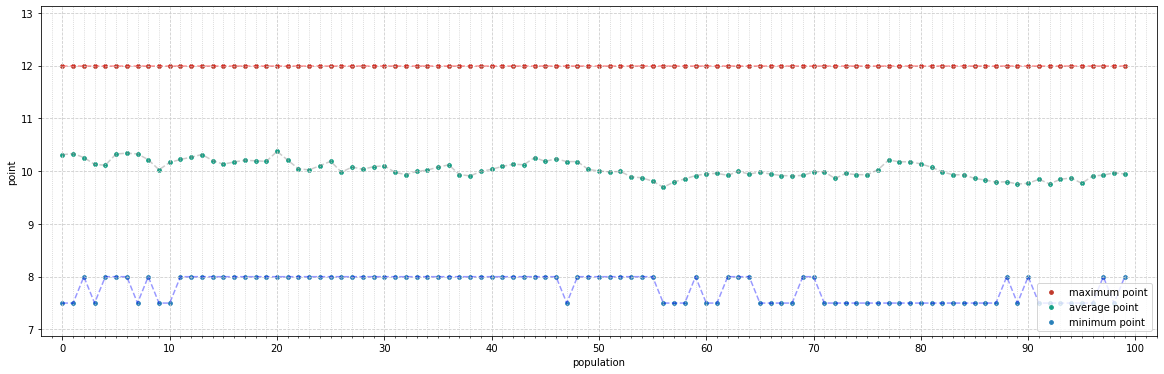

result for configuration 1 -----------------------


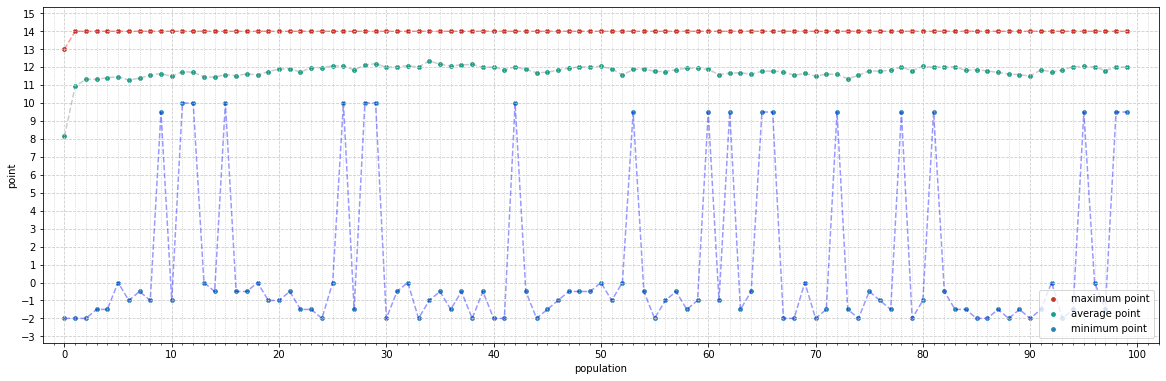

result for configuration 2 -----------------------


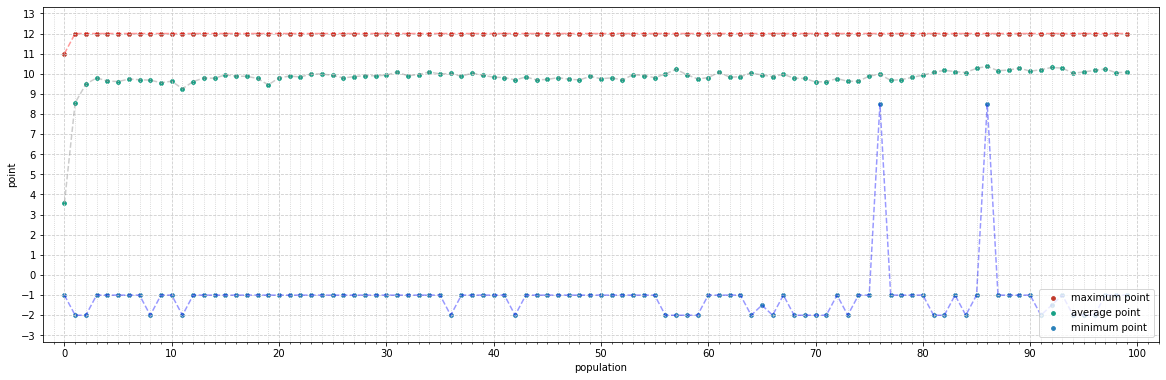

result for configuration 3 -----------------------


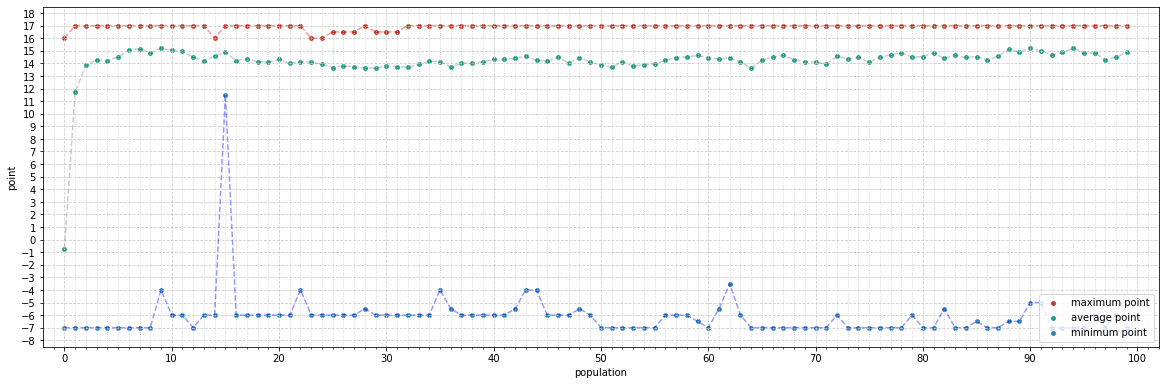

result for configuration 4 -----------------------


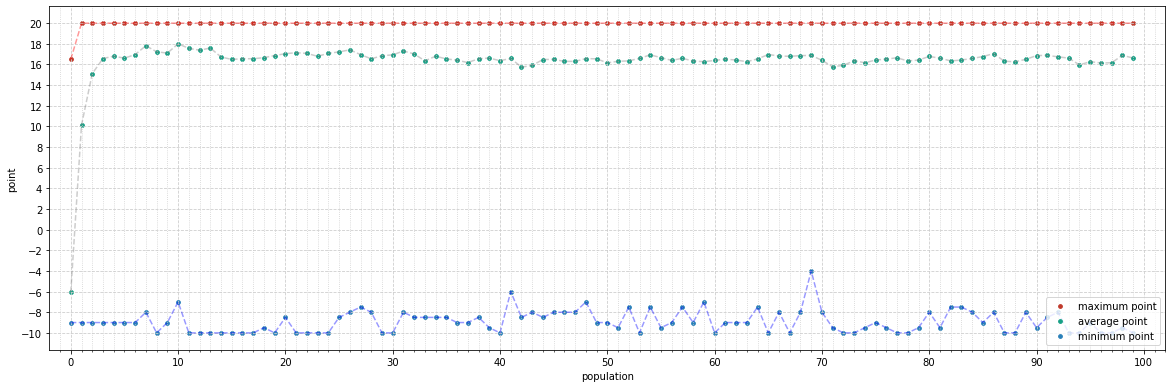

result for configuration 5 -----------------------


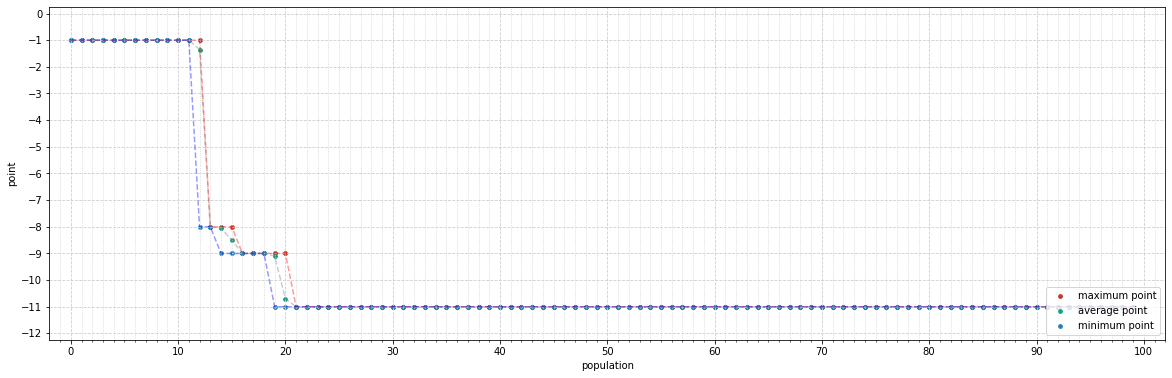

result for configuration 6 -----------------------


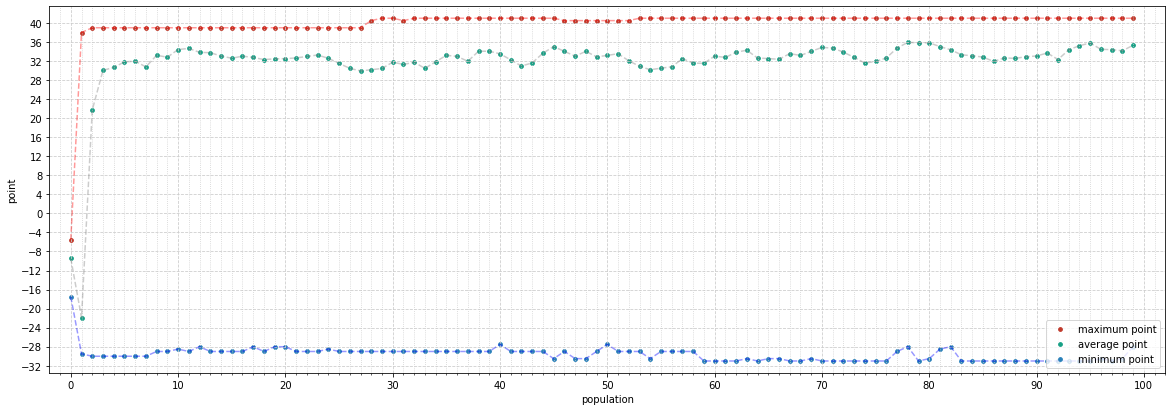

result for configuration 7 -----------------------


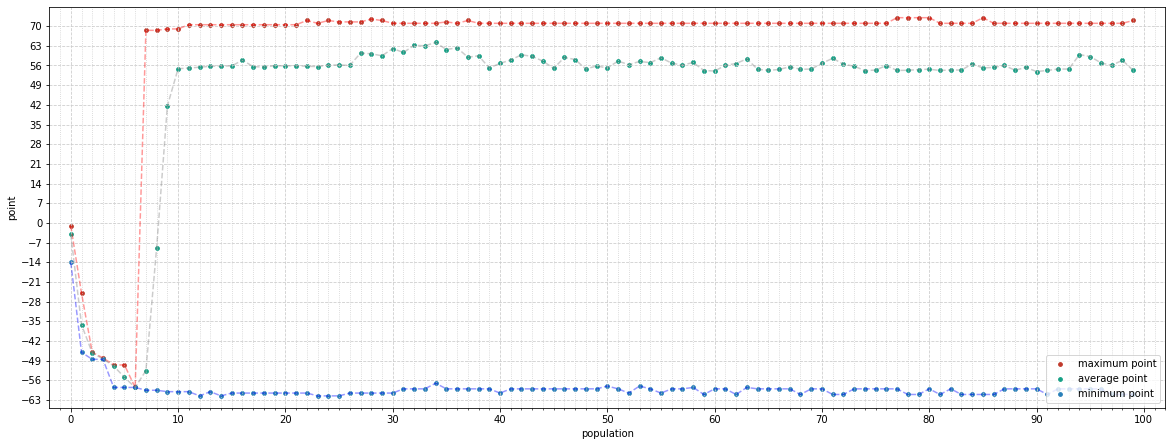

result for configuration 8 -----------------------


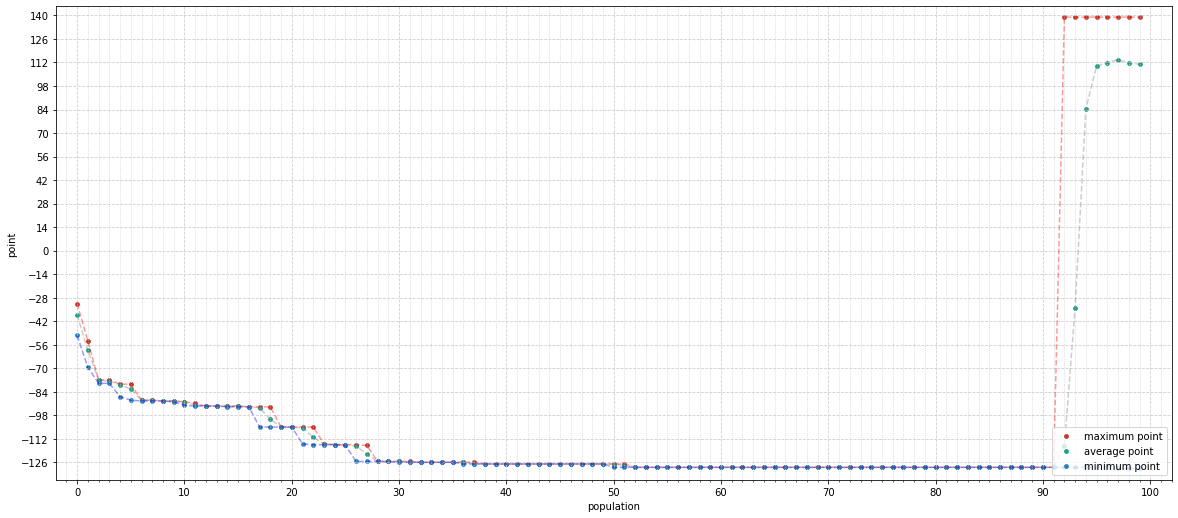

result for configuration 9 -----------------------


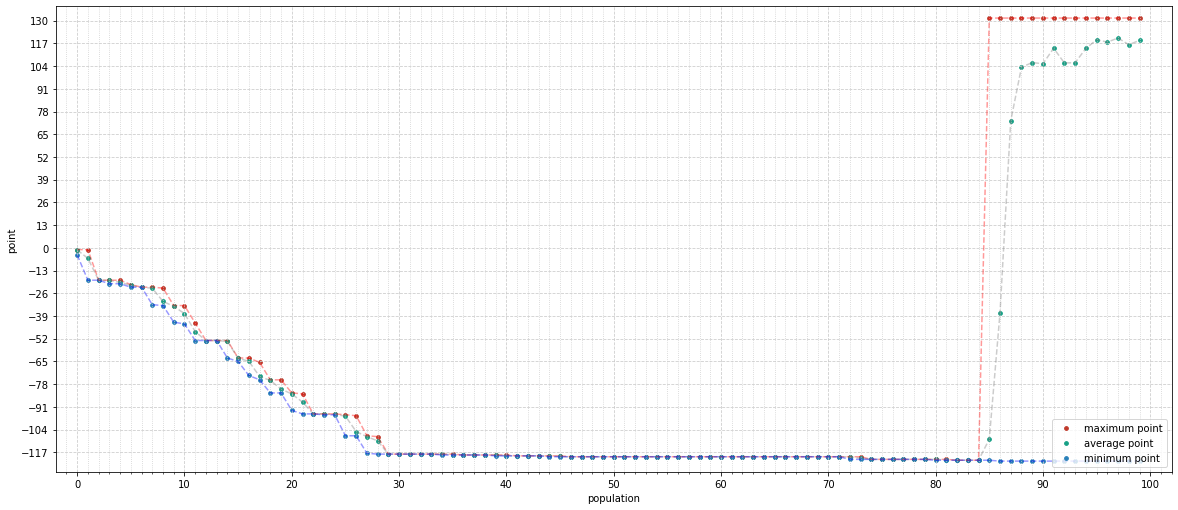

@@@ setting 1
result for configuration 0 -----------------------


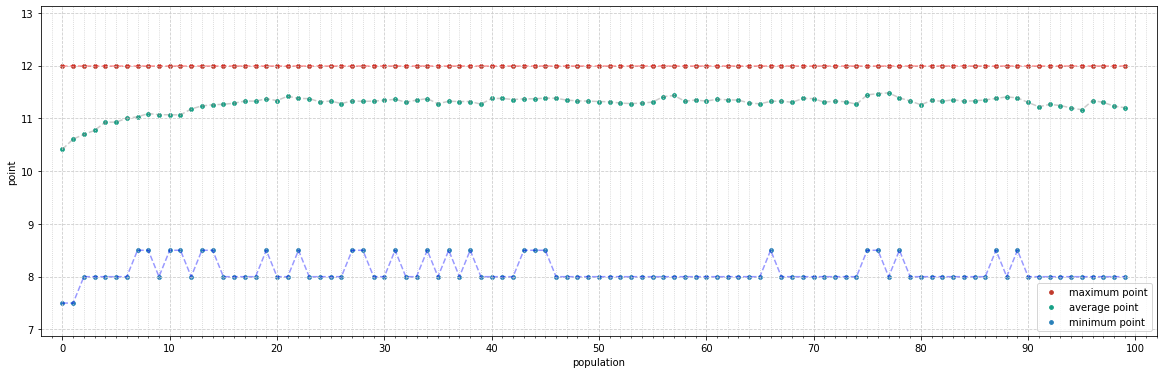

result for configuration 1 -----------------------


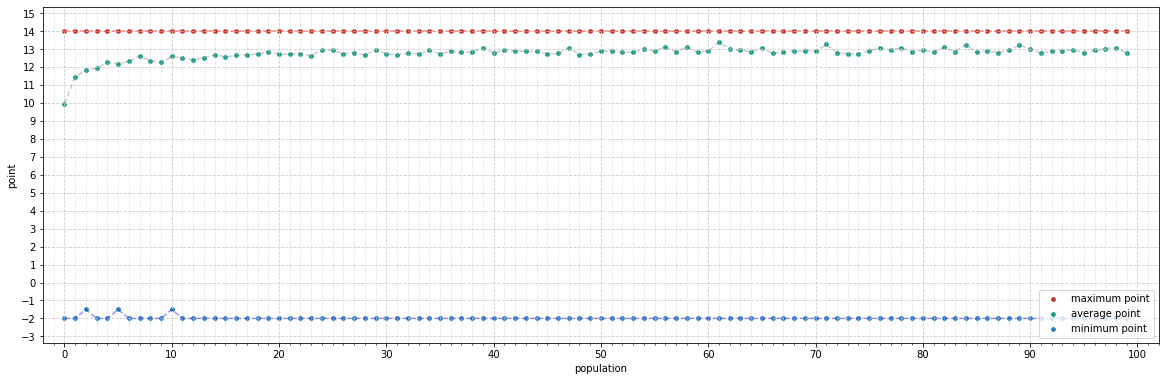

result for configuration 2 -----------------------


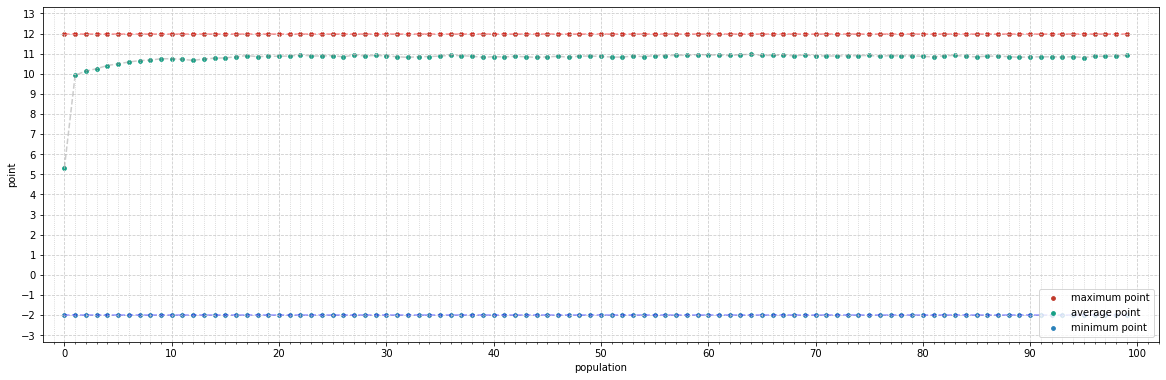

result for configuration 3 -----------------------


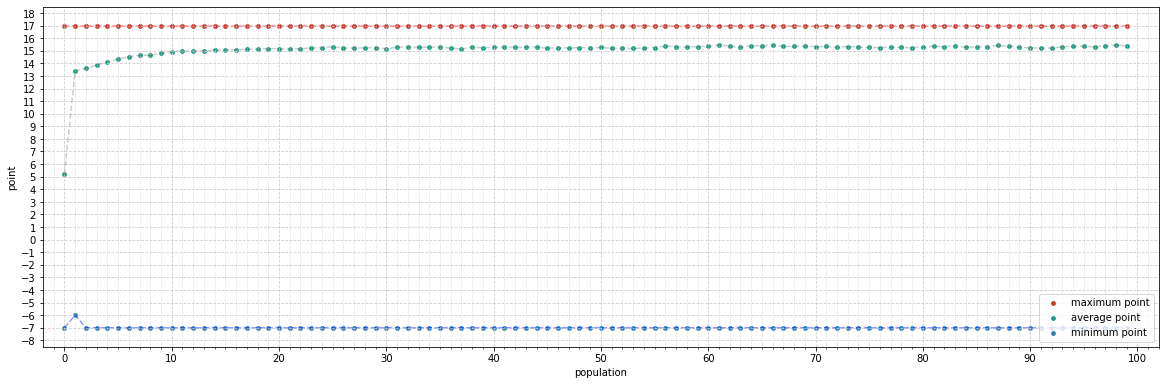

result for configuration 4 -----------------------


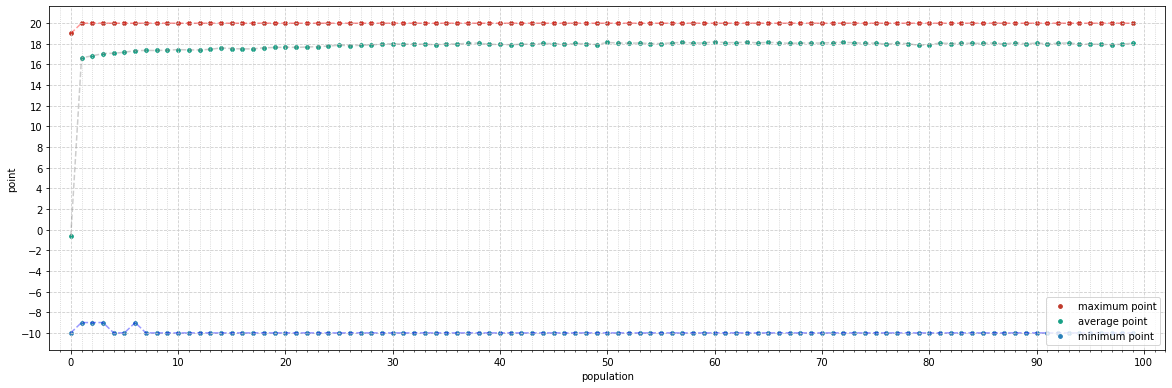

result for configuration 5 -----------------------


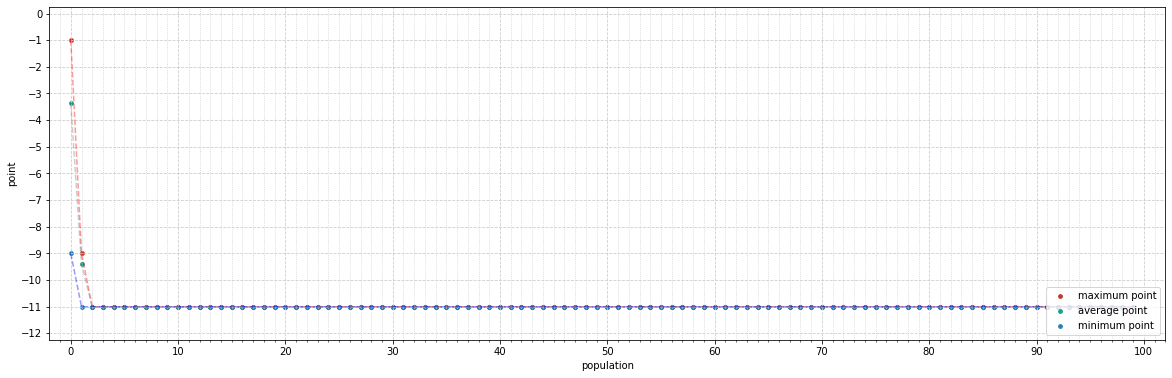

result for configuration 6 -----------------------


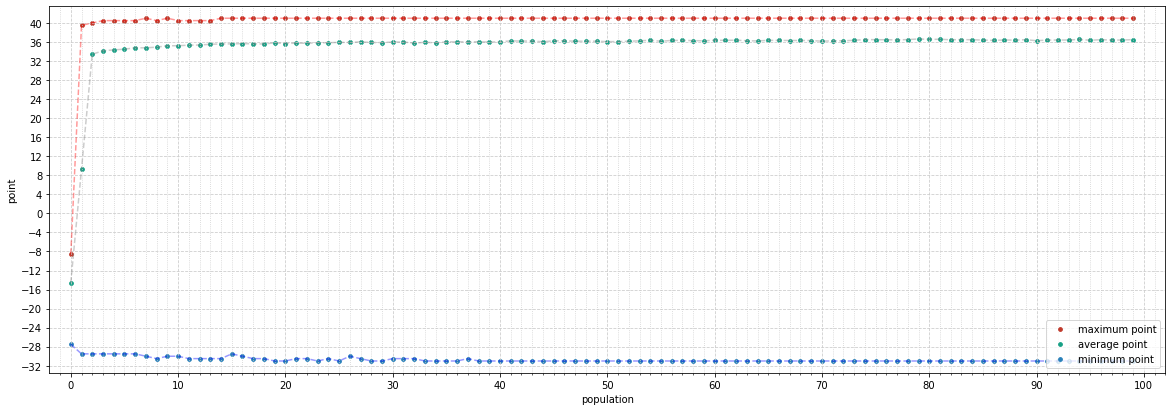

result for configuration 7 -----------------------


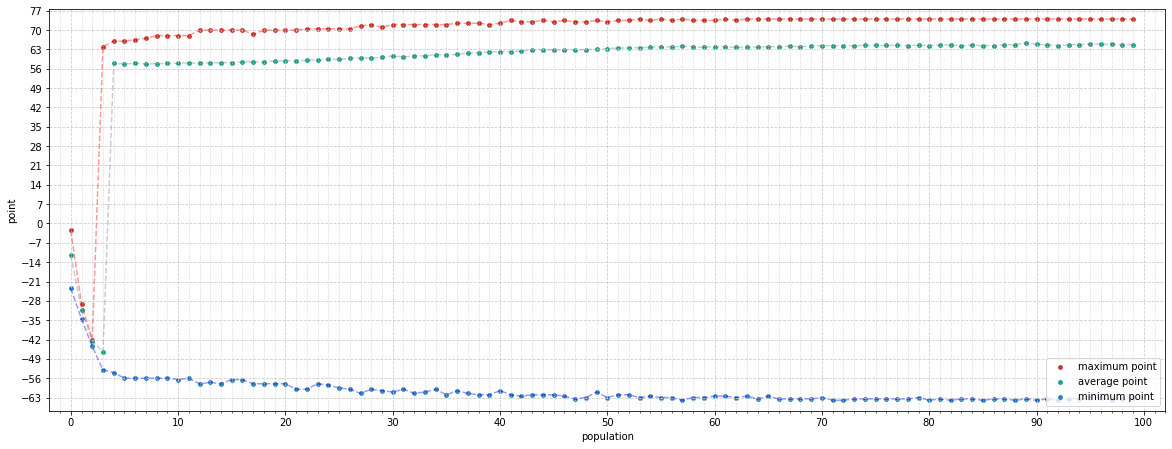

result for configuration 8 -----------------------


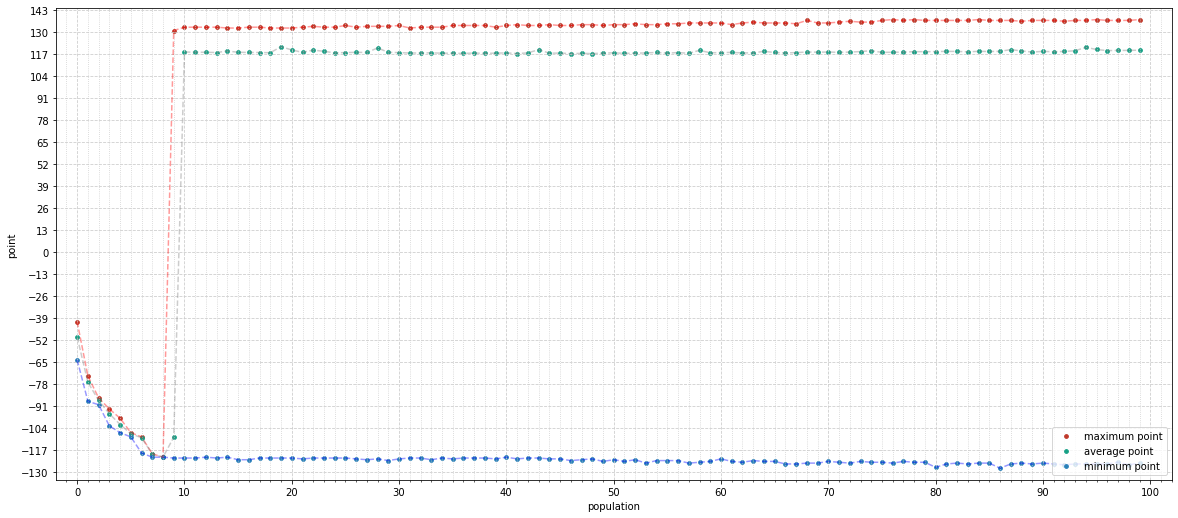

result for configuration 9 -----------------------


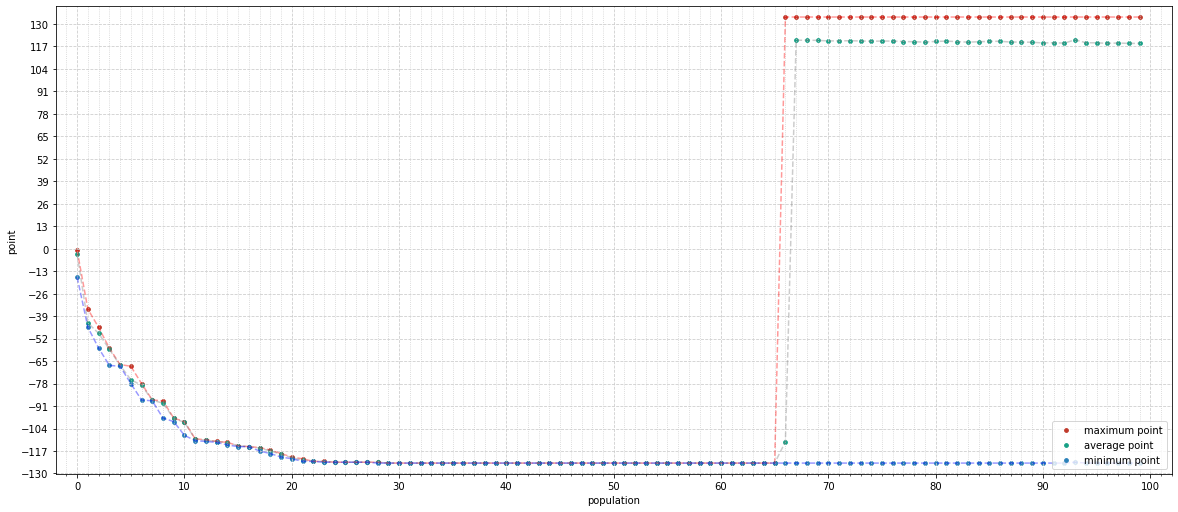

@@@ setting 2
result for configuration 0 -----------------------


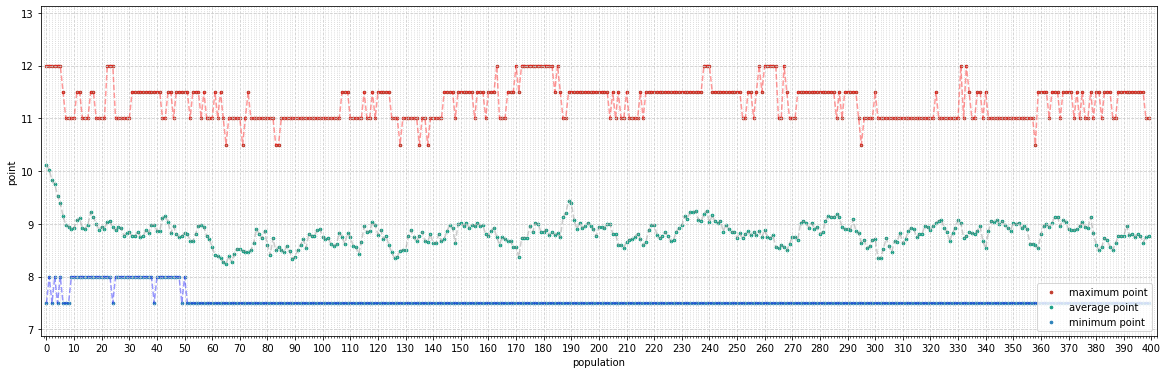

result for configuration 1 -----------------------


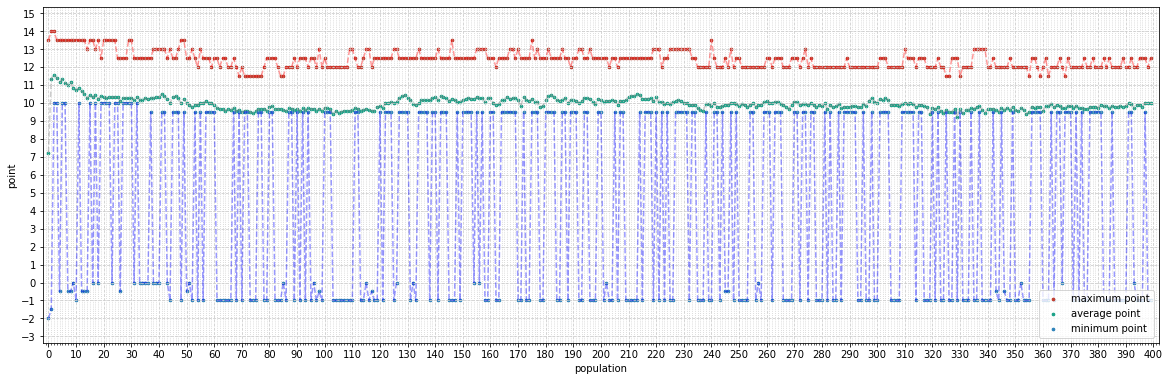

result for configuration 2 -----------------------


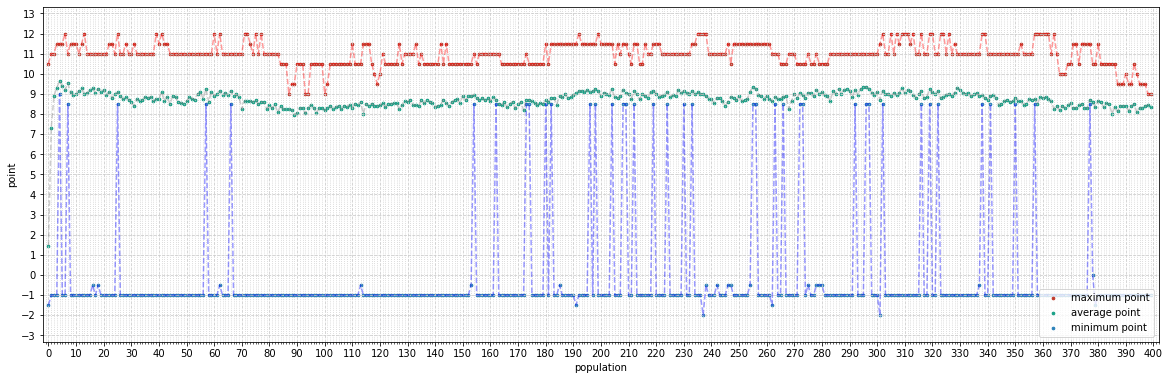

result for configuration 3 -----------------------


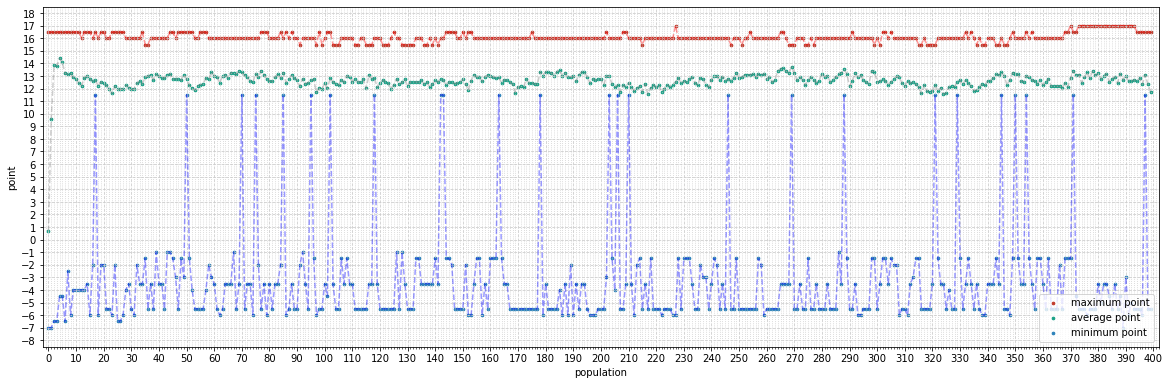

result for configuration 4 -----------------------


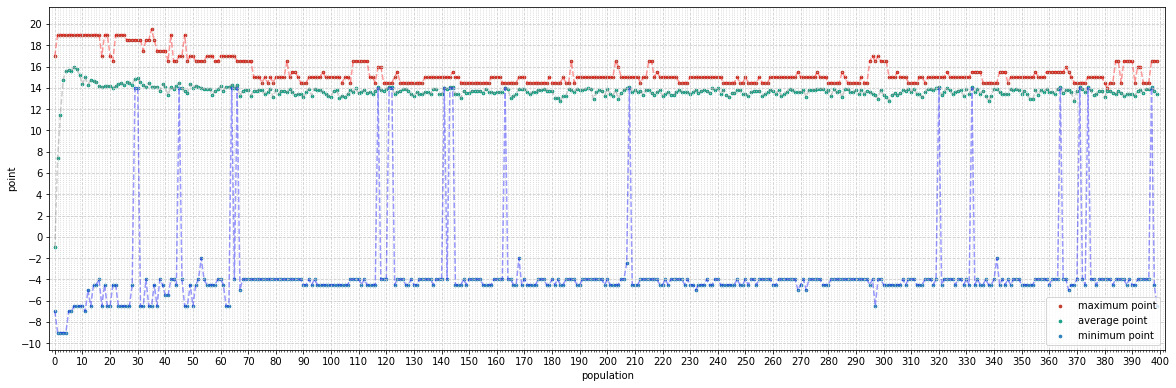

result for configuration 5 -----------------------


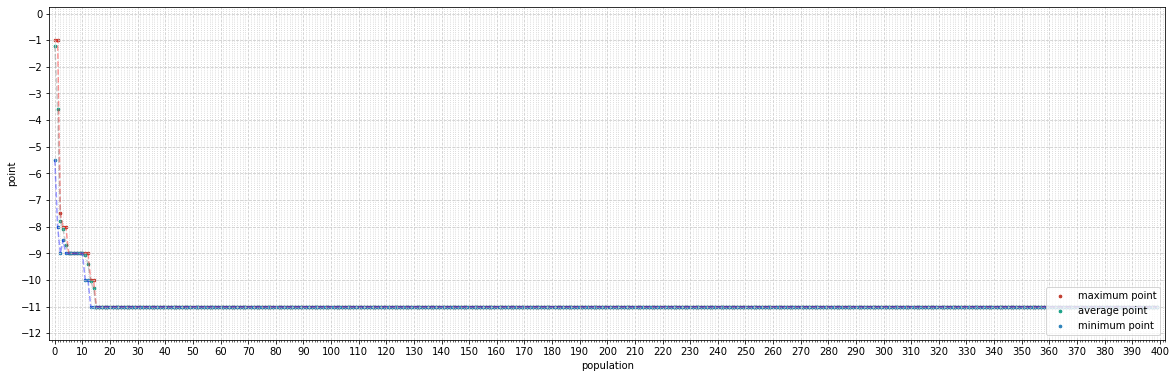

result for configuration 6 -----------------------


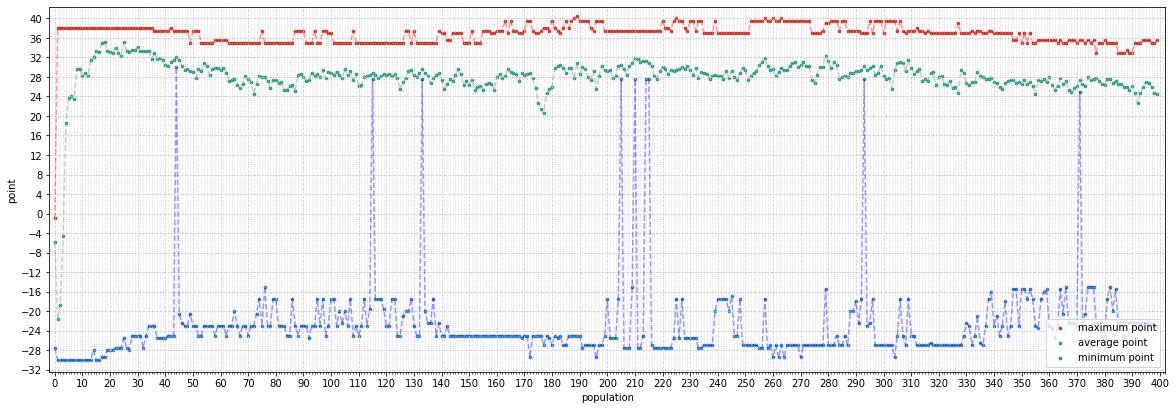

result for configuration 7 -----------------------


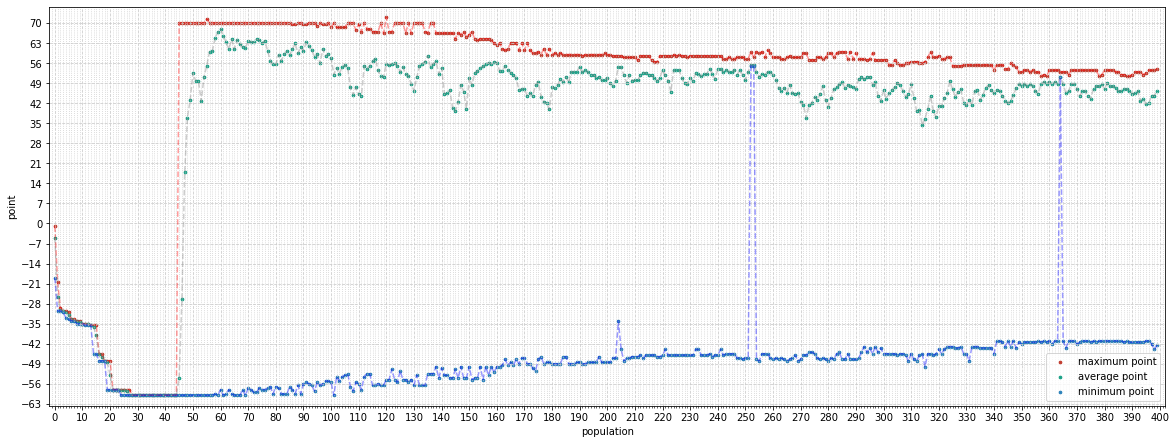

result for configuration 8 -----------------------


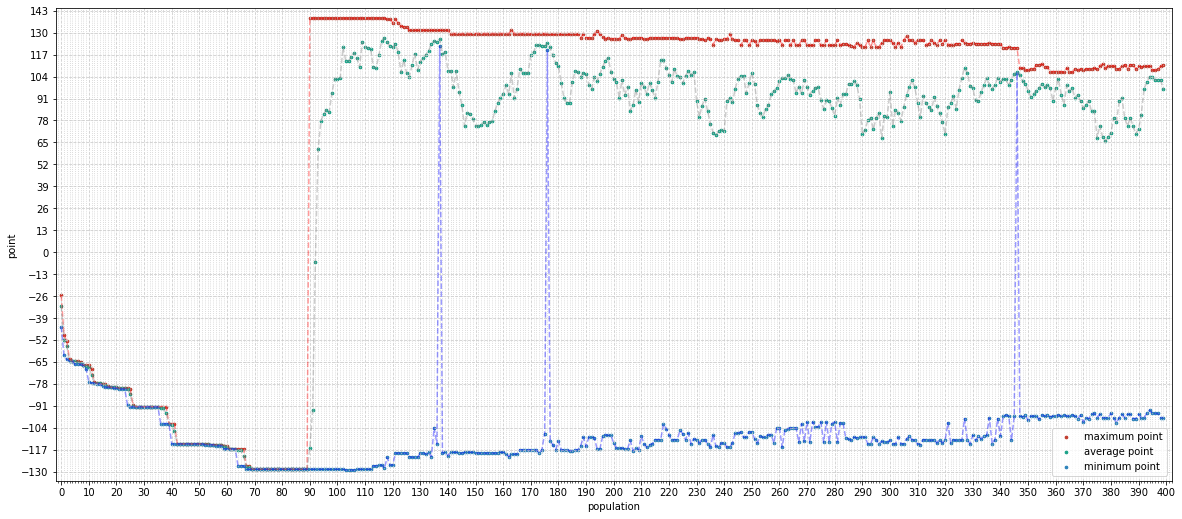

result for configuration 9 -----------------------


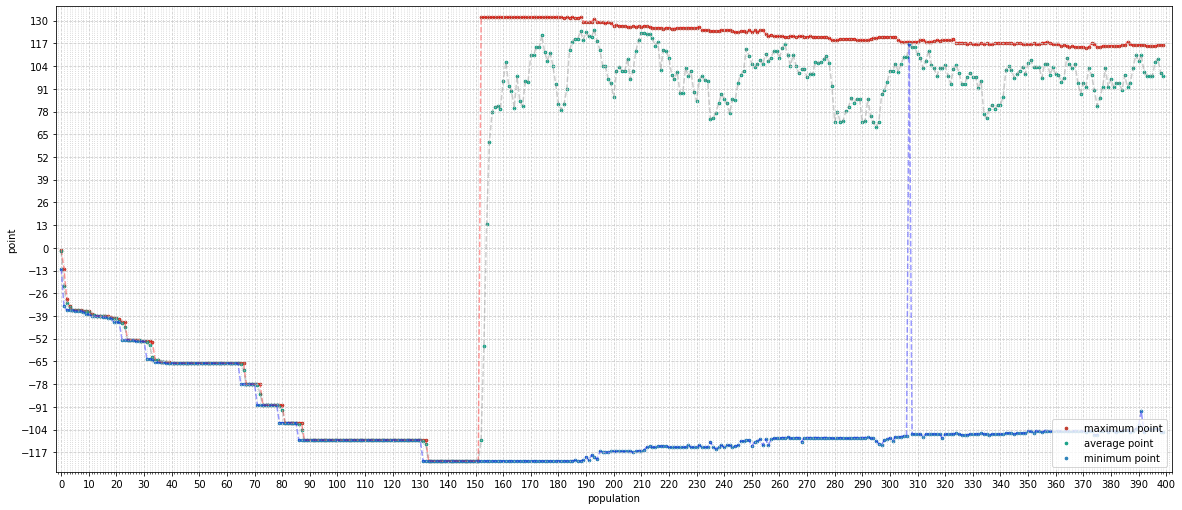

@@@ setting 3
result for configuration 0 -----------------------


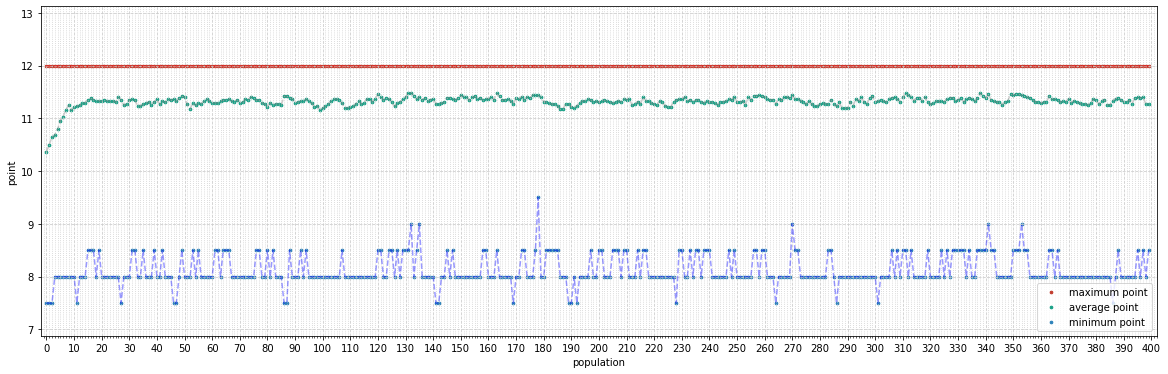

result for configuration 1 -----------------------


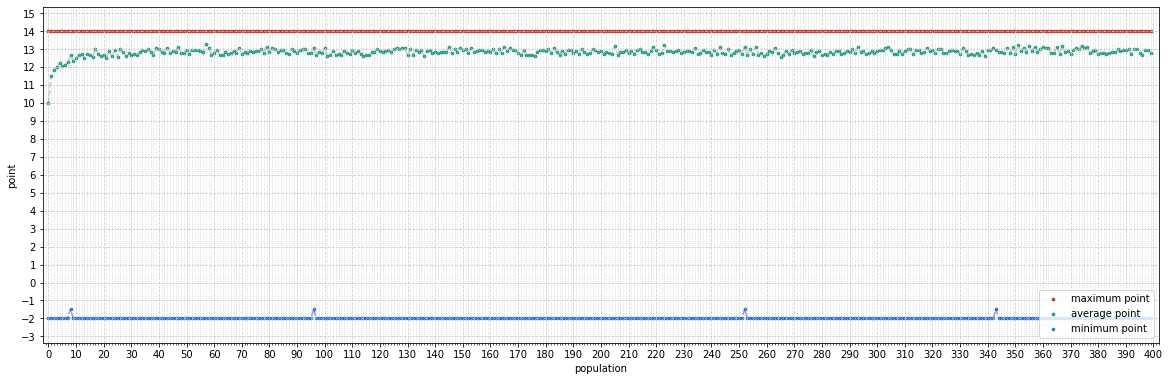

result for configuration 2 -----------------------


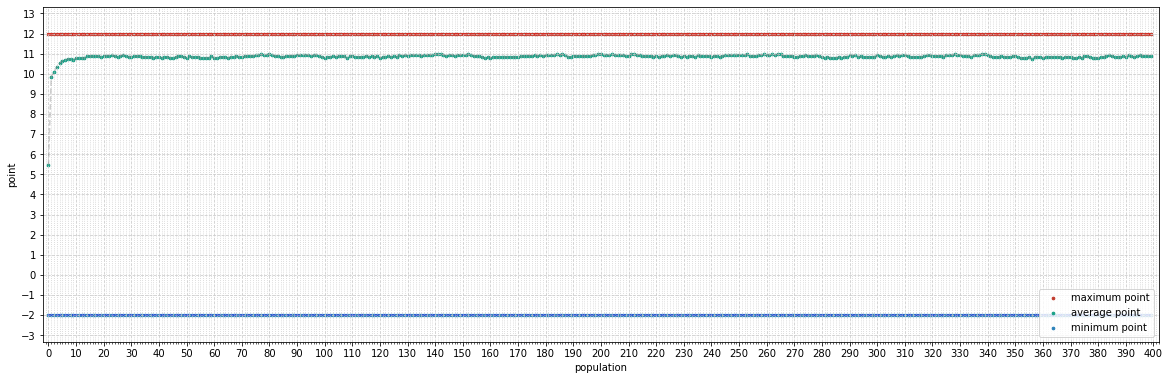

result for configuration 3 -----------------------


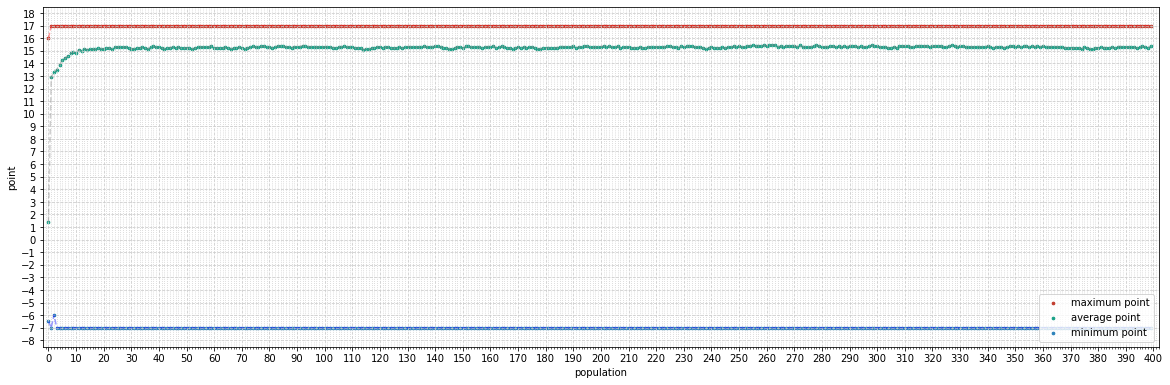

result for configuration 4 -----------------------


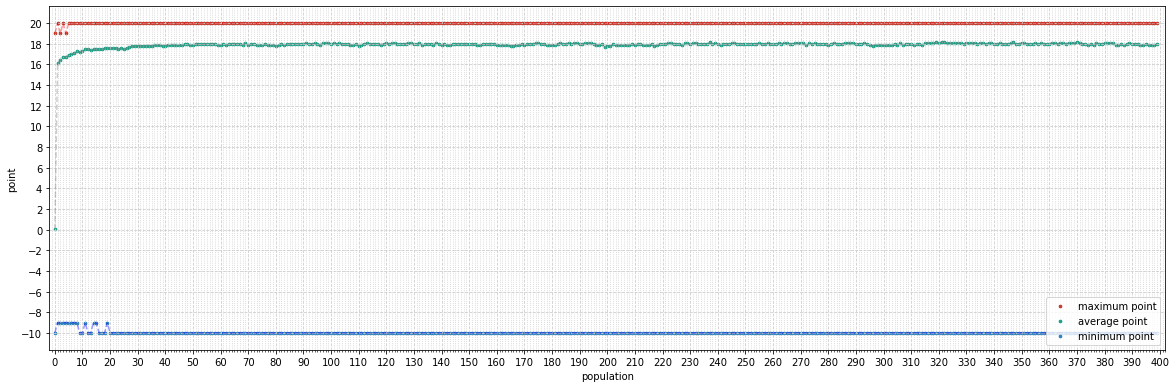

result for configuration 5 -----------------------


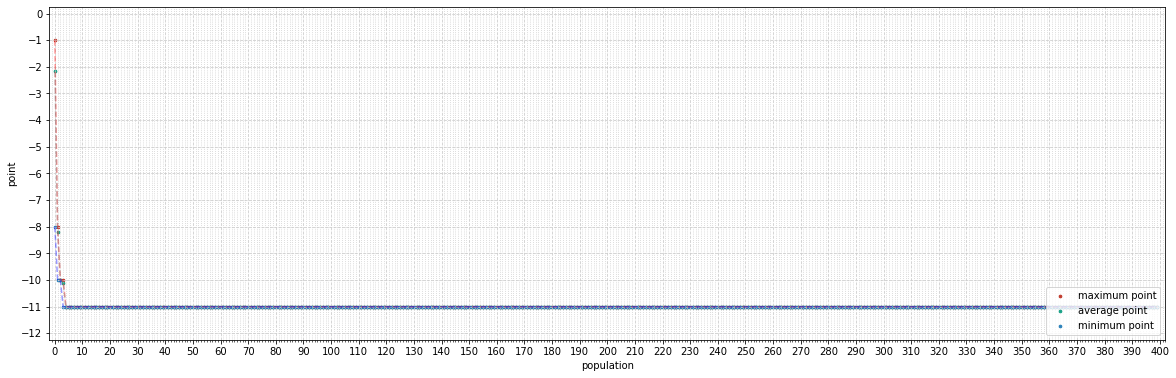

result for configuration 6 -----------------------


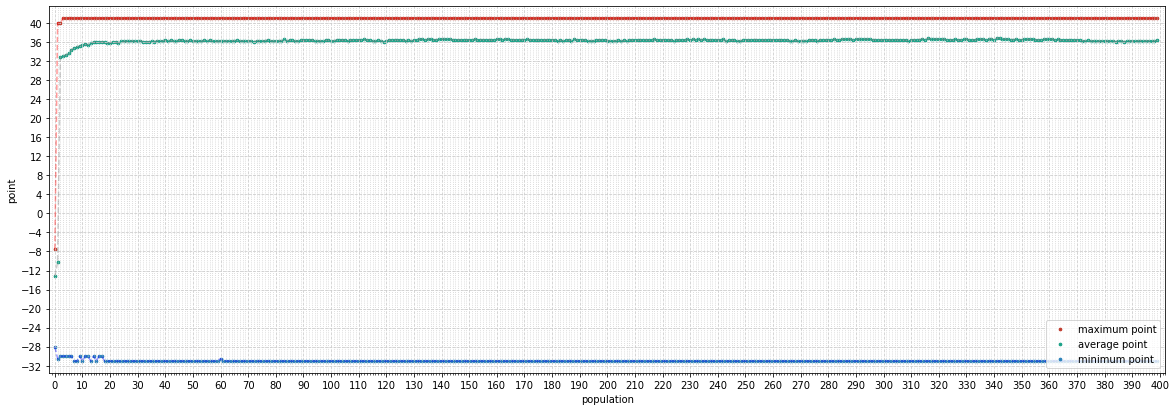

result for configuration 7 -----------------------


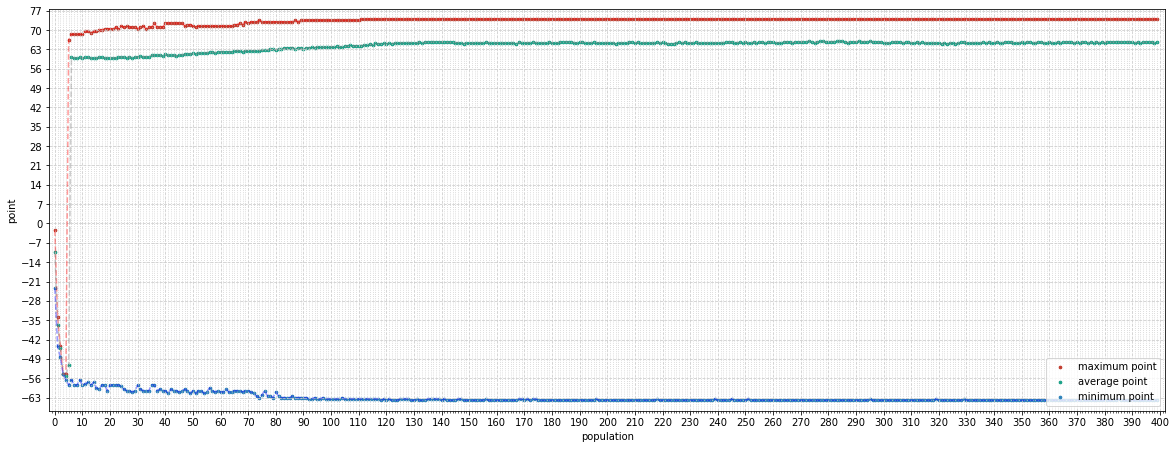

result for configuration 8 -----------------------


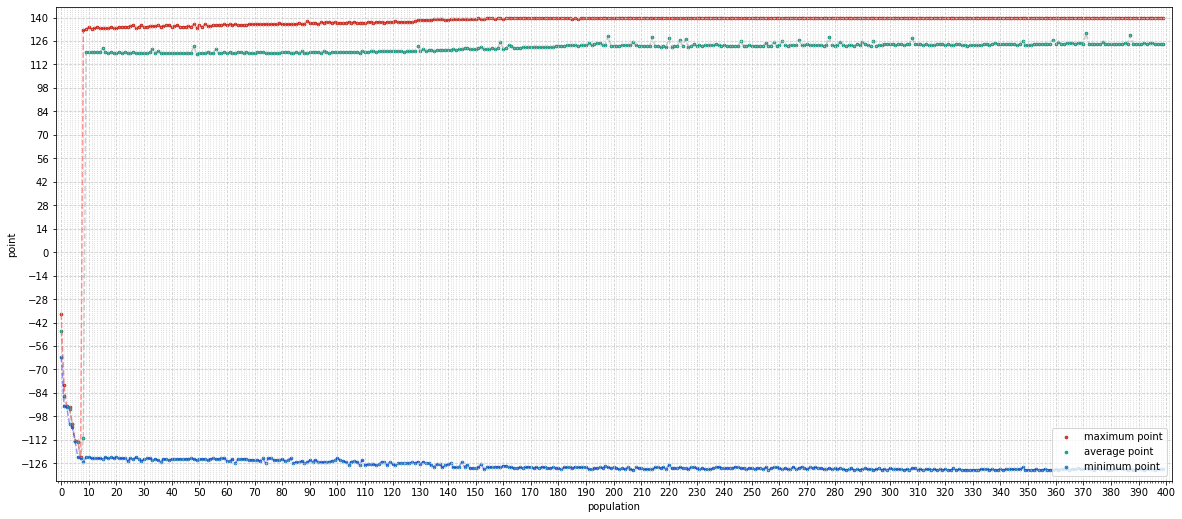

result for configuration 9 -----------------------


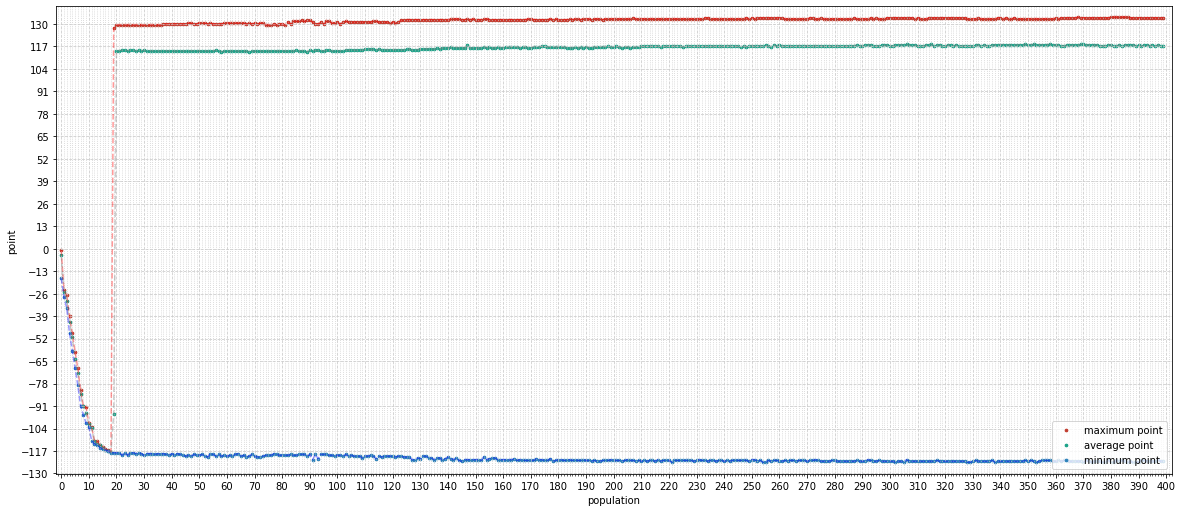

In [119]:
for setting_index, setting_result in enumerate(results):
    print(f"@@@ setting {setting_index}")
    for index, result in enumerate(setting_result):
        path = f"../output/plots/setting-{setting_index}"
        if result:
            print(f'result for configuration {index} -----------------------')
            draw_result(result, save=True, path=path, file_name=f'config-{index}.png', show=True, dpi=300)


## Exporting results as animations (Visualization)

In [123]:
import pprint
import subprocess

for setting_index, setting_result in enumerate(results):
    print(f'@  exporting result for setting {setting_index}')
    for index, res in enumerate(setting_result):
    
        path = f"../output/animations/setting-{setting_index}/config-{index}"
        game = Game(main_configurations[index])

        actions = res["last_population"][-1][0]
        score = game.score(actions)

        if score > 0:
            print(f'   exporting result for configuration {index}')
            steps = game.do_interactions(actions)
            conf = copy.deepcopy(main_configurations[index])
            for idx,s in enumerate(steps):
                conf['luigi']    = s['luigi']
                conf['mushroom'] = s['mushroom']
                conf['goomba']   = s['goomba']
                draw_config(conf, save=True, path=path, file_name=f'{idx + 1:04d}.png', show=False, dpi=100)

            cmd = ['ffmpeg', '-y', '-framerate', '3', '-i', f'{path}/%04d.png', f'{path}/output.gif']
            process = subprocess.run(cmd, capture_output=True, text=True)
        else:
            pass


#     for history_record in result['history']:
#         print(f"{history_record['min']}, {round(history_record['avg'], 3)}, {history_record['max']}")
#         print([x[1] for x in history_record['candidates']])
#         print([round(x,1) for x in history_record['dist']])

@  exporting result for setting 0
   exporting result for configuration 0
   exporting result for configuration 1
   exporting result for configuration 2
   exporting result for configuration 3
   exporting result for configuration 4
   exporting result for configuration 6
   exporting result for configuration 7
   exporting result for configuration 8
   exporting result for configuration 9
@  exporting result for setting 1
   exporting result for configuration 0
   exporting result for configuration 1
   exporting result for configuration 2
   exporting result for configuration 3
   exporting result for configuration 4
   exporting result for configuration 6
   exporting result for configuration 7
   exporting result for configuration 8
   exporting result for configuration 9
@  exporting result for setting 2
   exporting result for configuration 0
   exporting result for configuration 1
   exporting result for configuration 2
   exporting result for configuration 3
   exporting resul